# Moving average trading

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout
from ipywidgets import HBox, VBox, Label
from ipywidgets import interactive_output, jslink
from ipywidgets import FloatSlider, IntSlider, SelectionSlider, SelectionRangeSlider
from ipywidgets import FloatText, IntText
from IPython.display import display

import trading as tra
import trading_plots as trp
import trading_defaults as dft

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Default parameters

In [2]:
TICKER     = 'ETH-USD'

REFRESH    = False # Download fresh Yahoo data 

START_DATE = '2017-07-15'
END_DATE   = datetime.strftime(datetime.now()- timedelta(days = 1), '%Y-%m-%d') #yesterday
END_DATE = '2021-03-26'
print(END_DATE)

2021-03-26


### Data download

In [3]:
try:
    raw, ticker_name = tra.load_security(dirname = dft.DATA_DIR, 
                                        ticker  = TICKER, 
                                        refresh = REFRESH, 
                                        period  = dft.DEFAULT_PERIOD,
                                        )
    print (raw)
except IndexError:
        print(f'Could not load {TICKER}')
except:
    print(f'Error type {sys.exc_info()[0]}')
else:
    security = pd.DataFrame(raw[f'Close_{TICKER}'])
    security.rename(columns={f'Close_{TICKER}': "Close"},
                    inplace=True)

    security
    

Loading data from data/ETH-USD_5y.pkl
            Close_ETH-USD  Vol_ETH-USD
Date                                  
2016-03-27     10.4191999     16744800
2016-03-28     11.6655998     23188300
2016-03-29     11.6563997     17684200
2016-03-30     11.9528999     19351200
2016-03-31     11.4034996     14966700
...                   ...          ...
2021-03-23   1678.6501465  21998237965
2021-03-24   1593.4134521  31228051473
2021-03-25   1595.3592529  29650328701
2021-03-26   1702.8420410  22548516548
2021-03-27   1710.6166992  18059231232

[1823 rows x 2 columns]


#### Setup default start & end dates

In [4]:
# Check dates 
#print(tra.get_title_dates(security, START_DATE, END_DATE))
print(tra.get_datetime_date_range(security, START_DATE, END_DATE))
#print(tra.get_filename_dates(security, START_DATE, END_DATE))

[datetime.datetime(2017, 7, 15, 0, 0), datetime.datetime(2021, 3, 26, 0, 0)]


## Plotting functions

In [5]:
def plot_time_series(span, date_range, fee_pct, buffer):
    trp.plot_time_series(TICKER, ticker_name, date_range, security,span, fee_pct, buffer)

In [6]:
def plot_span_range(buffer, n_best, fee_pct, date_range):
    trp.plot_span_range(buffer     = buffer, 
                        n_best     = n_best, 
                        fee_pct    = fee_pct, 
                        date_range = date_range, 
                        ticker     = TICKER, 
                        ticker_name = ticker_name,
                        security   = security, 
                       )

In [7]:
#### test driver for trp.plot_span_range
plot = False

if plot:
    plot_span_range(buffer     = .01, 
                    n_best     = 12, 
                    fee_pct    = dft.FEE_PCT, 
                    date_range = [datetime.strptime(START_DATE, '%Y-%m-%d'), 
                                  datetime.strptime(END_DATE, '%Y-%m-%d')], 
                   )

In [8]:
def plot_buffer_range(span, n_best, fee_pct, date_range):
    trp.plot_buffer_range(span       = span, 
                          n_best     = n_best, 
                          fee_pct    = fee_pct, 
                          date_range = date_range, 
                          ticker     = TICKER, 
                          ticker_name = ticker_name,
                          security   = security, 
                         )

In [9]:
#### test driver for trp.plot_span_range
plot = False
if plot:
    plot_buffer_range(span       = 20, 
                      n_best     = 12, 
                      fee_pct    = dft.FEE_PCT, 
                      date_range = [datetime.strptime(START_DATE, '%Y-%m-%d'), 
                                    datetime.strptime(END_DATE, '%Y-%m-%d')], 
                     )

In [10]:
date_range = tra.get_datetime_date_range(security, START_DATE, END_DATE)
print(date_range)
#tra.read_ema_map(TICKER, date_range)
#ATO.PA_2017-07-15_2021-03-25_ema_map

[datetime.datetime(2017, 7, 15, 0, 0), datetime.datetime(2021, 3, 26, 0, 0)]


In [11]:
# Driver for plot_buffer_span_contours
plot = False
if plot:
    date_range = tra.get_datetime_date_range(security, START_DATE, END_DATE)
    
    print(tra.get_ema_map_filename(TICKER, date_range))
    if os.path.exists(tra.get_ema_map_filename(TICKER, date_range)):
        spans, buffers, emas, hold  = tra.read_ema_map(TICKER, date_range,)
    else: # If not saved, compute it
        spans, buffers, emas, hold = tra.build_ema_map(TICKER, security, date_range,)
    trp.plot_buffer_span_contours(TICKER, ticker_name, date_range, spans, buffers, emas, hold)
#ETH-USD_2017-07-15_2021-03-26_ema_map.csv

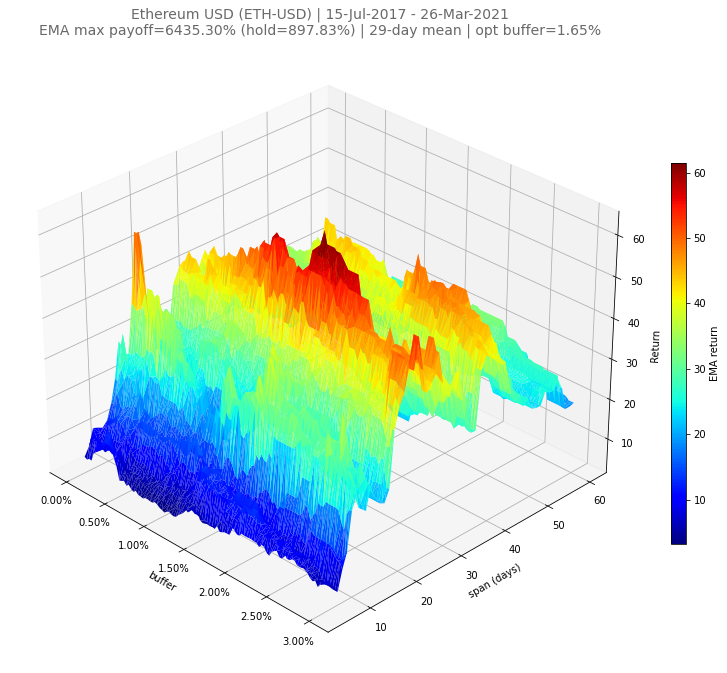

In [32]:
# Driver for plot_buffer_span_3D
plot = True
if plot:
    date_range = tra.get_datetime_date_range(security, START_DATE, END_DATE)
    if os.path.exists(tra.get_ema_map_filename(TICKER, date_range)):
        spans, buffers, emas, hold  = tra.read_ema_map(TICKER, date_range,)
    else: # If not saved, compute it
        spans, buffers, emas, hold = tra.build_ema_map(TICKER, security, date_range,)
    
    trp.plot_buffer_span_3D(TICKER, ticker_name, date_range, 
                            spans, buffers, emas, hold, 
                            elev=dft.PERSPECTIVE[0], azim=dft.PERSPECTIVE[1], rdist=dft.PERSPECTIVE2)

### Interactive plots

#### Widget defaults

In [13]:
def get_default_parameters(ticker, date_range):
    try: # ema file exists
        spans, buffers, emas, hold = tra.read_ema_map(ticker, date_range)
        df = tra.get_best_emas(spans, buffers, emas, hold, 1)
        opt_span, opt_buff , opt_ema, opt_hold = df.span[0], df.buffer[0], df.ema[0], df.hold[0]
    except Exception as ex:
        print(f'Could not process {ticker}: Exception={ex}') 
        raise ValueError('aborting')
        opt_span, opt_buff , opt_ema, opt_hold = dft.DEFAULT_SPAN, dft.DEFAULT_BUFFER, 0, 0 
    return opt_span, opt_buff , opt_ema, opt_hold

date_range = tra.get_datetime_date_range(security, START_DATE, END_DATE)
best_span, best_buffer, best_ema, hold = get_default_parameters(TICKER, date_range)
print(f'span={best_span:.0f}, buffer={best_buffer:.2%}, EMA={best_ema:.2%} hold={hold:.2%}')

span=29, buffer=1.65%, EMA=6435.30% hold=897.83%


In [14]:
### Default parameter values
string_style = {'description_width': 'initial', 
                'handle_color':      'lawngreen'}

start_period, end_period = tra.get_datetime_date_range(security, START_DATE, END_DATE)
dates        = pd.date_range(start_period, end_period, freq='D')
date_options = [(date.strftime(' %d/%m/%Y'), date) for date in dates]
date_index   = (0, len(date_options) - 1)

best_span, best_buffer, _, _ = get_default_parameters(TICKER, date_range)

# Tx/broker's fee
min_fee     = 0.0
max_fee     = .01
delta_fee   = .0005
default_fee = dft.FEE_PCT

# of days for running mean
min_span     = dft.MIN_SPAN
max_span     = dft.MAX_SPAN
delta_span   = 1
default_span = best_span

# buffer around EMA
min_buffer     = dft.MIN_BUFF
max_buffer     = dft.MAX_BUFF
delta_buffer   = .0001
default_buffer = best_buffer

# number of maxima
max_value     = 15
default_value = 12

# 3D horizontal & vertical sliders
min_azimuth     = dft.MIN_AZIMUTH
max_azimuth     = dft.MAX_AZIMUTH
delta_azimuth   = 1
default_azimuth = dft.PERSPECTIVE[0]

min_elevation     = dft.MIN_ELEVATION
max_elevation     = dft.MAX_ELEVATION
delta_elevation   = 1
default_elevation = dft.PERSPECTIVE[1]


AttributeError: module 'trading_defaults' has no attribute 'MIN_HORIZONTAL'

In [ ]:
## Widget methods
### Sliders
def get_span_slider():
    return IntSlider(min      = min_span,
                     max      = max_span,
                     step     = delta_span,
                     value    = default_span,
                     style    = string_style,
                     disabled = False,
                     continuous_update=False,
                     readout=True,
                     readout_format='d',
                     layout = {'width': '250px'},
                    )

def get_buffer_slider():
    return FloatSlider(min=min_buffer,
                        max=max_buffer,
                        step=delta_buffer,
                        value=default_buffer,
                        style=string_style,
                        continuous_update=False,
                        disabled=False,
                        readout=True,
                        readout_format='.2%',
                        layout      = {'width': '250px'},
                       )
    
def get_fee_slider():
    return FloatSlider(min=min_fee,
                       max=max_fee,
                       step=delta_fee,
                       value=default_fee,
                       style=string_style,
                       disabled=False,
                       continuous_update=False,
                       readout=True,
                       readout_format='.2%',
                       layout      = {'width': '250px'},
                      )

def get_max_values_slider():
    return SelectionSlider(options=[x for x in range(0, max_value+1)],
                          value=default_value,
                          description='Number of maxima:',
                          style=string_style,
                          disabled=False,
                          continuous_update=False,
                          readout=True,
                          readout_format='d',
                          layout      = {'width': '500px'},
                          )
                       
def get_date_range_slider():
    return SelectionRangeSlider(options  = date_options,
                                 index   = date_index,
                                 description = 'Period:',
                                 orientation = 'horizontal',
                                 style       = string_style,
                                 layout      = {'width': '500px'}
                                )

def get_horizontal_slider():
    return IntSlider(min      = min_horizontal,
                     max      = max_horizontal,
                     step     = delta_horizontal,
                     value    = default_horizontal,
                     style    = string_style,
                     disabled = False,
                     continuous_update=False,
                     readout=True,
                     readout_format='d',
                     layout = {'width': '250px'},
                    )

def get_vertical_slider():
    return IntSlider(min      = min_vertical,
                     max      = max_vertical,
                     step     = delta_vertical,
                     value    = default_vertical,
                     style    = string_style,
                     disabled = False,
                     continuous_update=False,
                     readout=True,
                     readout_format='d',
                     layout = {'width': '250px'},
                    )

### Text boxes
def get_fee_text_box():
    return FloatText(min=min_fee,
                     max=max_fee,
                     step=delta_fee,
                     value=default_fee,
                     description='Fees:',
                     style=string_style,
                     disabled=False,
                     readout_format='6.3%',
                     layout={'width': '150px'},
                    )
                       
def get_span_text_box():
    return IntText(min   = min_span,
                   max   = max_span,
                   step  = delta_span,
                   value = default_span,
                   style          = string_style,
                   disabled       = False,
                   description    = 'Span:',
                   readout_format = 'd',
                   layout={'width': '150px'},
                   )
                       
def get_buffer_text_box():
    return FloatText(min   = min_fee,
                     max   = max_fee,
                     step  = delta_fee,
                     value = default_fee,
                     style       = string_style,
                     disabled    = False,
                     description = 'Buffer:',
                     readout_format = '3%',
                     layout = {'width': '150px'},
                    )

#### Interactive returns for window span

In [ ]:
# Mean window span range optimizer interactive
buffer_slider   = get_buffer_slider()
buffer_text_box = get_buffer_text_box()
buffer_link     = jslink((buffer_slider, 'value'), (buffer_text_box, 'value'))

max_values_slider   = get_max_values_slider()

fee_slider   = get_fee_slider()
fee_text_box = get_fee_text_box()
fee_link     = jslink((fee_slider, 'value'), (fee_text_box, 'value'))

date_range_slider = get_date_range_slider()

fee_widgets    = HBox([fee_text_box, fee_slider])
buffer_widgets = HBox([buffer_text_box, buffer_slider])

out = interactive_output(plot_span_range,
                         {'buffer'    : buffer_slider,
                          'n_best'    : max_values_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                         }
                        )

ui = TwoByTwoLayout(top_left     = fee_widgets,
                    top_right    = date_range_slider,
                    bottom_left  = buffer_widgets,
                    bottom_right = max_values_slider,
                   )

display(ui, out)

#### Interactive returns for buffer size

In [ ]:
# Buffer range optimizer interactive 
span_slider   = get_span_slider()
span_text_box = get_span_text_box()
span_link     = jslink((span_slider, 'value'), (span_text_box, 'value'))

max_values_slider = get_max_values_slider()

fee_slider   = get_fee_slider()
fee_text_box = get_fee_text_box()
fee_link     = jslink((fee_slider, 'value'), (fee_text_box, 'value'))

date_range_slider = get_date_range_slider()

fee_widgets    = HBox([fee_text_box, fee_slider])
span_widgets = HBox([span_text_box, span_slider])

out = interactive_output(plot_buffer_range,
                         {'span'      : span_slider,
                          'n_best'    : max_values_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                          }
                         )

ui = TwoByTwoLayout(top_left     = fee_widgets,
                    top_right    = date_range_slider,
                    bottom_left  = span_widgets,
                    bottom_right = max_values_slider,
                    )

display(ui, out)

#### Interactive buffer-span

In [ ]:
# Buffer-span interactive plot
fee_slider   = get_fee_slider()
fee_text_box = get_fee_text_box()
fee_link     = jslink((fee_slider, 'value'), (fee_text_box, 'value'))

span_slider   = get_span_slider()
span_text_box = get_span_text_box()
span_link     = jslink((span_slider, 'value'), (span_text_box, 'value'))

buffer_slider   = get_buffer_slider()
buffer_text_box = get_buffer_text_box()
buffer_link     = jslink((buffer_slider, 'value'), (buffer_text_box, 'value'))

date_range_slider = get_date_range_slider()

out = interactive_output(plot_time_series,
                         {'span'      : span_slider,
                          'buffer'    : buffer_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                          }
                         )

fee_widgets    = HBox([fee_text_box, fee_slider])
span_widgets   = HBox([span_text_box, span_slider])
buffer_widgets = HBox([buffer_text_box, buffer_slider])

ui = TwoByTwoLayout(top_left     = fee_widgets,
                    top_right    = date_range_slider,
                    bottom_left  = span_widgets,
                    bottom_right = buffer_widgets,
                   )

display(ui, out)

#### Interactive 3D plot

In [ ]:
# Buffer-span interactive plot
vertical_slider   = get_vertical_slider()
vertical_text_box = get_vertical_text_box()
fee_link     = jslink((vertical_slider, 'value'), (vertical_text_box, 'value'))

horizontal_slider   = get_horizontal_slider()
horizontal_text_box = get_horizontal_text_box()
fee_link     = jslink((horizontal_slider, 'value'), (horizontal_text_box, 'value'))